<a href="https://colab.research.google.com/github/AndreaCamilloni/BTC-price-prediction/blob/main/BTC_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 17.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
# Raw Package
import numpy as np
import pandas as pd

#Data Source
import yfinance as yf

#Data viz
import plotly.graph_objs as go

import pylab as p
import matplotlib.pyplot as plt
from collections import Counter
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller


# Get Bitcoin data
# list of crptocurrencies as ticker arguments: cryptocurrencies = ['BNB-USD','BTC-USD', 'ETH-USD', 'XRP-USD']
#data = yf.download(tickers='BTC-USD',  interval = '1d',period = '2000d')
data = yf.download(tickers='BTC-USD',  interval = '1d', start='2017-01-01', end='2020-10-31'
                     )

#27-06-2014 until 27-06-2019 => A LSTM-Method for Bitcoin Price Prediction: A Case Study Yahoo Finance Stock Market
#1 January 2017 to 31 October 2020 => An Advanced CNN-LSTM Model for Cryptocurrency Forecasting

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


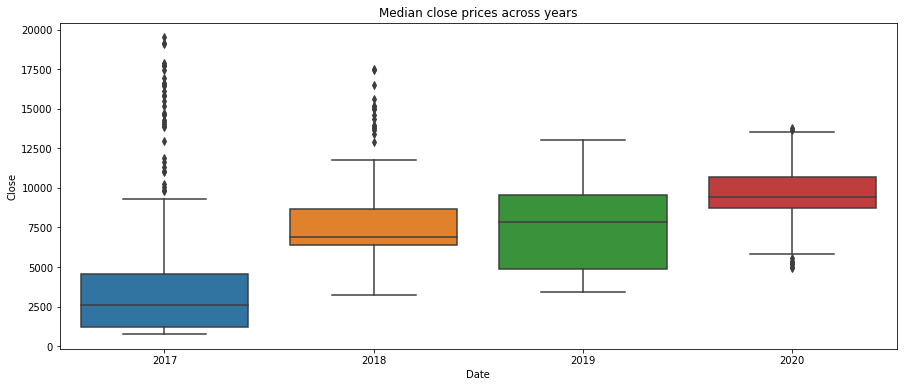

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(15,6))
ax.set_title("Median close prices across years")
sns.boxplot(pd.PeriodIndex(data.index, freq='Y'), data.Close, ax=ax)

In [ ]:
print("Number of samples: ", len(data))
print('Bitcoin data from', data.index[0], "to", data.index[-1])

Number of samples:  1400
Bitcoin data from 2017-01-01 00:00:00 to 2020-10-31 00:00:00


# Data analysis
The chart below, shows the opening, closing, highest, and lowest prices experienced within a trading day for the first quarter. If the opening price was higher than the closing price, the box is filled in red, whereas if the closing price was higher than the opening price, the box is green. 

This type of plot is potentially more useful than a time series plot of just the closing (or opening) prices, because it shows the volatility of the stock within a trading day. 

In [ ]:
#declare figure
fig = go.Figure()

#Candlestick
fig.add_trace(go.Candlestick(x=data.index,
open=data['Open'],
high=data['High'],
low=data['Low'],
close=data['Close'], name = 'market data'))

# Add titles
fig.update_layout(
title='Bitcoin live share price evolution',
yaxis_title='Bitcoin Price (kUS Dollars)')

# X-Axes
fig.update_xaxes(
  rangeslider_visible=True,
  rangeselector=dict(
  buttons=list([
  dict(count=15, label="15m", step="minute", stepmode="backward"),
  dict(count=45, label="45m", step="minute", stepmode="backward"),
  dict(count=1, label="HTD", step="hour", stepmode="todate"),
  dict(count=6, label="6h", step="hour", stepmode="backward"),
  dict(step="all")])))

In our work we will consider only the closing price.

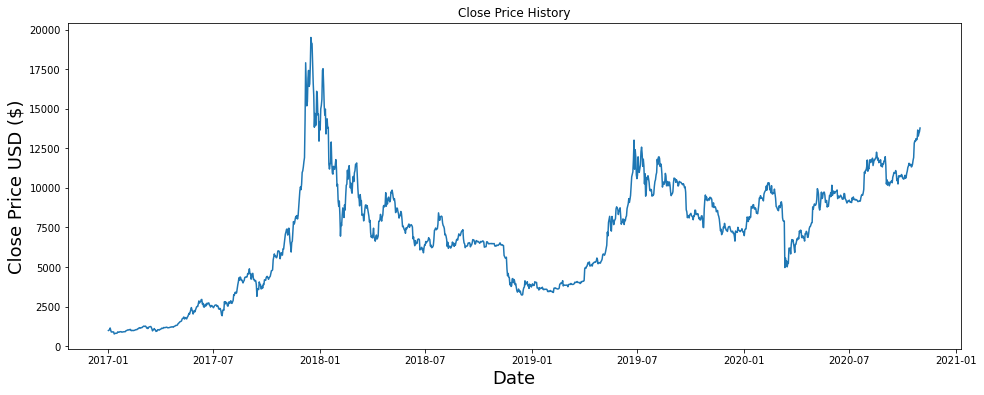

In [ ]:
close = data['Close']

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(data['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Above is shown the trend of the closing prices.

We can observe means, variances, and covariances that change over time, so probably we have a non-stationary time series.

Bitcoin’s seasonality fluctuations are increasing year-on-year.

Further consideration on non-stationarity can be done by considering some test on unit roots.

**Non Stationarity**

A time series is said to be **strictly stationary** if its properties are not affected by a change in the time origin.
Stationary time series is characterized by constant mean and constant variance; a stationary time series tends to vary around a fixed level, and does not present any kind of Trend or Seasonal components.

The stock price does not seem to vary around a fixed level, this behaviour is typical of **nonstationary** time series.

## Augmented Dickey-Fuller Test
The Augmented Dickey-Fuller test is a type of statistical test called a unit root test for checking the stationarity of a time serie.


*  Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

*  Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

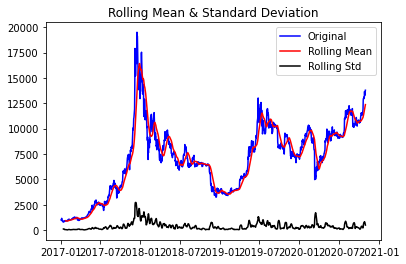

ADF test statistic: -2.263287
p-value: 0.184082
Critical values:
	1%: -3.435 
	5%: -2.864 
	10%: -2.568 
The timeseries is not stationary


False

In [ ]:
def plot_statistics(x):
  #Determing rolling statistics
  rolmean = x.rolling(window=22,center=False).mean()

  rolstd = x.rolling(window=12,center=False).std()
  
  #Plot rolling statistics:
  orig = plt.plot(x, color='blue',label='Original')
  mean = plt.plot(rolmean, color='red', label='Rolling Mean')
  std = plt.plot(rolstd, color='black', label = 'Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block=False)
  
  
def is_stationary(time_series, confidence_interval = 0.05, critical_value = 1): #critical values: 0 = 1%, 1 = 5%, 2 = 10%
    plot_statistics(time_series)
    #Perform augmented Dickey-Fuller test    
    test_result = adfuller(time_series)

    test_statistic = test_result[0]
    p_value = test_result[1]
    critical_values = list(test_result[4].values())

    print('ADF test statistic: %f' %test_statistic)
    print('p-value: %f'%p_value)
    print('Critical values:')
    for key,value in test_result[4].items():
        print('\t%s: %.3f ' % (key, value))

    if p_value > 0.05 and test_statistic > critical_values[critical_value]:
      print("The timeseries is not stationary")
      return False

    else:
      print("The timeseries is stationary")
      return True

           
is_stationary(close, 0.05, 1)

Test Statistic is greater than any critical values.

The p-value obtained is greater than significance level of 5% and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

Test Statistic is -2.077883 is greater than any critical values.
p-value is 0.253500

The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values.

Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.

Further stationarity test can be done, like the KPSS Test, but we consider just the ADF test, because we know for sure that the bitcoin time series is non-stationary.

From now on we will construct our models, and we will try them first on **NON-STATIONARY** and then on **STATIONARY** data obtained by performing the returns trasformation

# Non-Stationary data

In this section we propose two different architectures both trained on the original time series without performing any kind of transformation*.

Proposed models will employed two differents method:
*   LSTM (Long short time memory)
*   SVR (Support vector regression)


**the original time series will be pre-processed only to fit the models*

As said before we have to pre-process our data, data we will also split in training, test and validation:
*  85% training and validation data (10% of this new set will be dedicated for validation)
*  15% testing data

Since we are dealing with time series we will not shuffle the samples.

In [ ]:
time_steps = 14 #this is the time lag we will use for defining the lstm input

train_size = int(np.ceil( len(close) * .89 ))



dataset = data.filter(['Close']).values
train_df = dataset[:train_size] #this will be splitted into valid & train during training of the model
test_df = dataset[train_size-time_steps:] #we subtract the time lag, in order to have one-step ahead prediction starting from the last y_train

print("Train size: ", train_size-int(train_size*.1) )
print("Validation size: ", int(train_size*.1) )
print("Test size: ", len(close)-train_size)

Train size:  1122
Validation size:  124
Test size:  154


Data must be scaled in a range [0,1] in order too make the training phase much easier. This normalization can be useful, and even required in some machine learning algorithms when our time series data has input values with differing scales.

In [ ]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_df)
scaled_test = scaler.fit_transform(test_df) #


**LSTM**

For our first model we have to prepare the data to fit the model.

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

* Samples: One sequence is one sample. A batch is comprised of one or more samples.
* Time Steps: One time step is one point of observation in the sample.
* Features: One feature is one observation at a time step.

This means that the input layer expects a 3D array of data when fitting the model and when making predictions, even if specific dimensions of the array contain a single value, e.g. one sample or one feature.

=> input shape will be as follows (samples, num_timesteps, num_features)

In [ ]:
# Create the scaled training data set
train_data = scaled_train

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, 0])
    
    y_train.append(train_data[i, 0])


# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
        
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #[samples, time_steps, num_features]

print("x_train: ",x_train.shape, " = (samples, time_steps, num_features)")
print("y_train: ",y_train.shape)

x_train:  (1232, 14, 1)  = (samples, time_steps, num_features)
y_train:  (1232,)


In [ ]:
x_train[0].shape

(14, 1)

When defining the input layer of our LSTM network, the network assumes we have 1 or more samples and requires that we specify the number of time steps and the number of features. We can do this by specifying a tuple to the “input_shape” argument.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping  

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=60, epochs=500,validation_split=0.1,
callbacks=[EarlyStopping(monitor='val_loss', patience=15)], verbose=1, shuffle=False)

Epoch 1/500
19/19 [==============================] - 10s 202ms/step - loss: 0.0123 - val_loss: 0.0022
Epoch 2/500
19/19 [==============================] - 1s 74ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 3/500
19/19 [==============================] - 1s 71ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 4/500
19/19 [==============================] - 2s 87ms/step - loss: 0.0060 - val_loss: 0.0023
Epoch 5/500
19/19 [==============================] - 2s 91ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 6/500
19/19 [==============================] - 2s 97ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 7/500
19/19 [==============================] - 2s 86ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 8/500
19/19 [==============================] - 2s 87ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 9/500
19/19 [==============================] - 1s 75ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 10/500
19/19 [==============================] - 2s 103ms/step - loss: 0.0036 - val_loss: 0.0

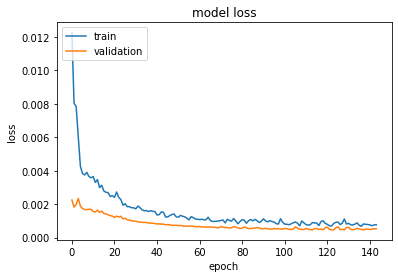

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

# Create the testing data set
test_data = scaled_test
# Create the data sets x_test and y_test
x_test = []
y_test = test_df[time_steps:]###########################################
for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
#print(x_test.shape)
#print(predictions.shape)

predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse_lstm_nonstat = np.sqrt(np.mean(((predictions - y_test) ** 2)))
mae_lstm_nonstat = mean_absolute_error(predictions, y_test)

print("MAE: " , mae_lstm_nonstat)
print("RMSE: " , rmse_lstm_nonstat)

MAE:  177.64304738230518
RMSE:  265.1160002280217


Below, are shown the actual close price and the predicted one.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



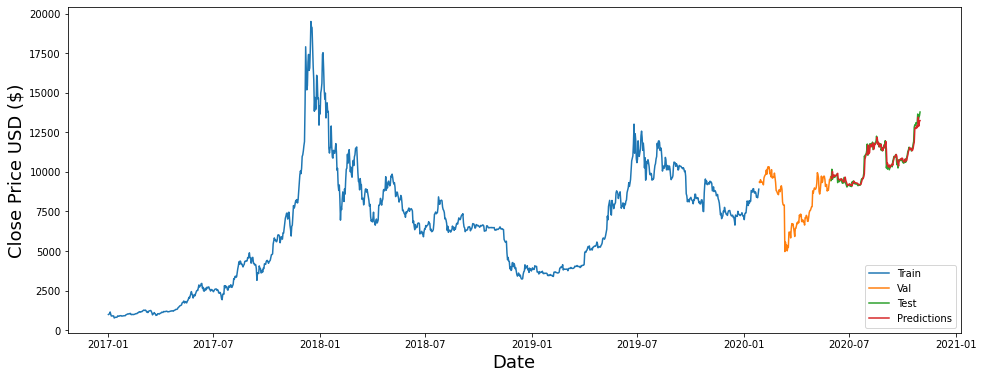

In [ ]:
train = data[:train_size-int(train_size*.1)]
valid = data[train_size-int(train_size*.1):train_size]
test = data[train_size:]
test['Predictions-LSTM'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(test[['Close', 'Predictions-LSTM']])
plt.legend(['Train', 'Val', 'Test','Predictions'], loc='lower right')
plt.show()


**SVR**

In [ ]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf',gamma=0.31, C=10, epsilon = 0.05) #better
#gamma=0.31, C=10, epsilon=0.05
#A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly. 
#gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected.

#svr_linear = SVR(kernel= 'linear', C= 1e3)
svr.fit(x_train[:,:,0], y_train)

pred_svm = svr.predict(x_test[:,:,0])
pred_svm = np.reshape(pred_svm, (pred_svm.shape[0], 1) )

pred_svm = scaler.inverse_transform(pred_svm)

# Get the root mean squared error (RMSE)
rmse_svm = np.sqrt(np.mean(((pred_svm - y_test) ** 2)))
rmse_svm, svr.score(x_test[:,:,0], y_test)

(279.5408625495791, -81.76343496551077)

In [ ]:
mean_absolute_error(pred_svm, y_test)

195.906141512913

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



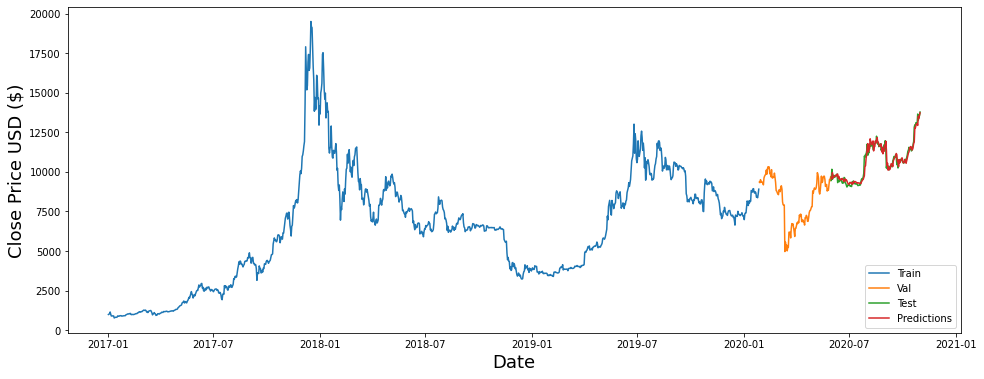

In [ ]:
test['Predictions-SVM'] = pred_svm

# Visualize the data
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(test[['Close', 'Predictions-SVM']])
plt.legend(['Train', 'Val', 'Test','Predictions'], loc='lower right')
plt.show()

**Results**

In [ ]:
print("RMSE lstm with nonstationary data:" , rmse_lstm_nonstat)
print("RMSE svr with nonstationary data:" , rmse_svm)

RMSE lstm with nonstationary data: 265.1160002280217
RMSE svr with nonstationary data: 279.5408625495791


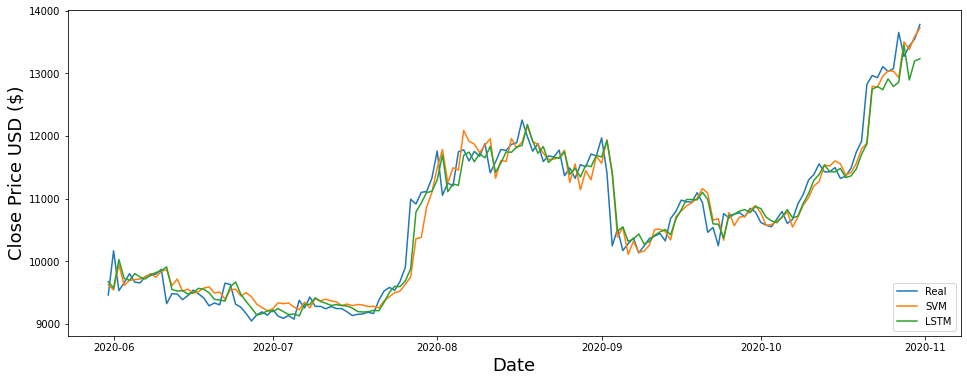

In [ ]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(test[['Close', 'Predictions-SVM', 'Predictions-LSTM']])
plt.legend(['Real', 'SVM', 'LSTM'], loc='lower right')
plt.show()

# Stationary data

As mentioned above, our time series is non stationary. We can try to stationarize it to achieve better performance and make the network learning phase much easier.


In order to have stationary data we have to transform the time series using some methods like first differences or returns.

We have applied the first difference transformation, which consists in differencing with one step shift, and then we check for stationarity, performing ADF test. 

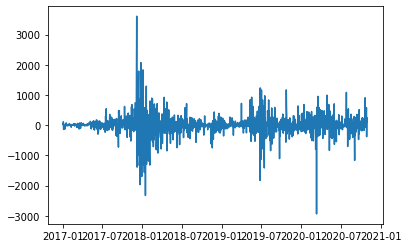

In [ ]:
diff_close = close.diff(1)
plt.plot(diff_close)
plt.show()

Check for stationarity 

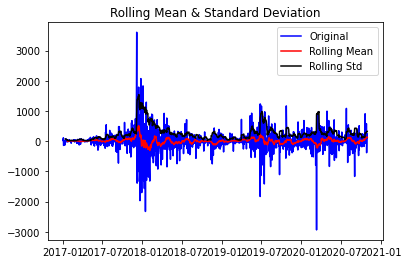

ADF test statistic: -7.231526
p-value: 0.000000
Critical values:
	1%: -3.435 
	5%: -2.864 
	10%: -2.568 
The timeseries is stationary


True

In [ ]:
diff_close.dropna(inplace=True)
is_stationary(diff_close)

In [ ]:
data['Stat-Close'] = diff_close
data

,Open,High,Low,Close,Adj Close,Volume,Stat-Close
Date,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008,NaN
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992,23.424988
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000,22.089966
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984,110.890015
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008,-141.349976
...,...,...,...,...,...,...,...
2020-10-27,13075.242188,13759.668945,13060.837891,13654.218750,13654.218750,33749878156,578.970703
2020-10-28,13654.214844,13837.695312,12932.250977,13271.285156,13271.285156,35867318895,-382.933594
2020-10-29,13271.298828,13612.047852,12980.059570,13437.882812,13437.882812,56499499598,166.597656


In [ ]:
stat_df = data.filter(['Stat-Close']).values 

train_size_stat = train_size-1 #since we have lost one value after differentiation
stat_df = stat_df[1:]

stat_train_df = stat_df[:train_size_stat] #this will splitted into valid & train during training of the model
stat_test_df = stat_df[train_size_stat-time_steps:] #we subtract the time lag, but the number of samples will be the same

**Normalization of the training set**

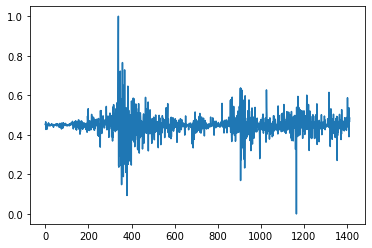

In [ ]:
min = stat_train_df.min()
max = stat_train_df.max()
scaled_stat_train = (stat_train_df - min) / (max-min)
scaled_stat_test = (stat_test_df - min) / (max-min)

plt.plot(np.concatenate((scaled_stat_train,scaled_stat_test)))


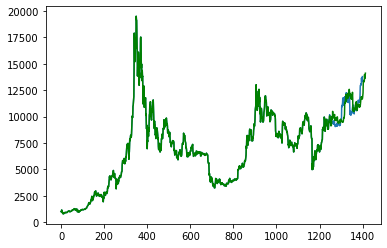

In [ ]:
#plt.plot(scaler.inverse_transform(scaled_stat_data).cumsum(),color= 'b')
plt.plot(close.values)
reconstructed_close = (np.concatenate((scaled_stat_train,scaled_stat_test))*(max-min)+min).cumsum()+close[0]
reconstructed_close = np.insert(reconstructed_close,0,close[0])

# data['Stat-Close'] = diff_close.cumsum()+close[0]
# data['Stat-Close'][0] = close[0]
# # data
plt.plot(reconstructed_close, color='g')

In [ ]:
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(time_steps, len(scaled_stat_train)):
    x_train.append(scaled_stat_train[i-time_steps:i, 0])
    
    y_train.append(scaled_stat_train[i, 0])

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
        
# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #[samples, time_steps, num_features]

In [ ]:
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense, LSTM

from keras.callbacks import EarlyStopping  

model = Sequential()

model.add(LSTM(units = 240,return_sequences=True, input_shape= (x_train.shape[1], 1))) #with more units and layer we can notice overfitting => with this configuration seems to work

model.add(Dropout(0.2))

model.add(LSTM(units = 60, ))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
 
# Train the model
history_stat = model.fit(x_train, y_train, batch_size=60, epochs=10,validation_split=0.2,
callbacks=[EarlyStopping(monitor='val_loss', patience=5)], verbose=1, shuffle=False)

Epoch 1/10
17/17 [==============================] - 6s 141ms/step - loss: 0.0340 - val_loss: 0.0026
Epoch 2/10
17/17 [==============================] - 1s 84ms/step - loss: 0.0050 - val_loss: 0.0026
Epoch 3/10
17/17 [==============================] - 2s 92ms/step - loss: 0.0039 - val_loss: 0.0026
Epoch 4/10
17/17 [==============================] - 1s 88ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 5/10
17/17 [==============================] - 2s 91ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 6/10
17/17 [==============================] - 1s 85ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 7/10
17/17 [==============================] - 2s 92ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 8/10
17/17 [==============================] - 2s 92ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/10
17/17 [==============================] - 2s 94ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 10/10
17/17 [==============================] - 2s 93ms/step - loss: 0.0036 - val_loss: 0.0025


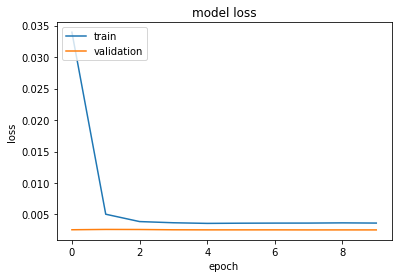

In [ ]:
plt.plot(history_stat.history['loss'])
plt.plot(history_stat.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

(154, 14, 1)
(154, 1)
2970.6191645081753


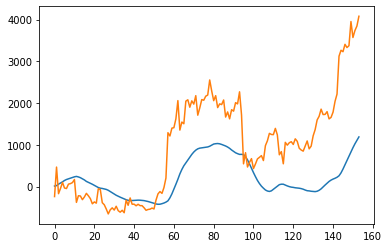

In [ ]:
# Create the testing data set
test_data = scaled_stat_test
# Create the data sets x_test and y_test
x_test = []
y_test = scaled_stat_test[time_steps:, :]
for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
pred = model.predict(x_test)
print(x_test.shape)
print(pred.shape)

predictions = pred*(max-min)+min

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((((pred - y_test)*(max-min)+min) ** 2)))
print(rmse)
plt.plot(predictions.cumsum())
plt.plot((y_test*(max-min)+min).cumsum())

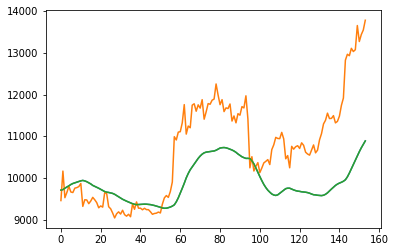

In [ ]:
p = np.concatenate((scaled_stat_train*(max-min)+min, predictions)).cumsum()[-predictions.shape[0]:]
df = predictions.cumsum() + close[train_size_stat]
plt.plot(df)
plt.plot(close[-predictions.shape[0]:].values)
plt.plot(p+close[0])

In [ ]:
#train = data[:train_size_stat]
#test = data[train_size_stat:]
#data['Stat-Close'][0]=0

# reconstructed_close = (np.concatenate((scaled_stat_train,scaled_stat_test))*(max-min)+min).cumsum()+close[0]
# reconstructed_close = np.insert(reconstructed_close,0,close[0])

#test['Stat-Close'].cumsum()+close[train_size_stat-1], test['Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



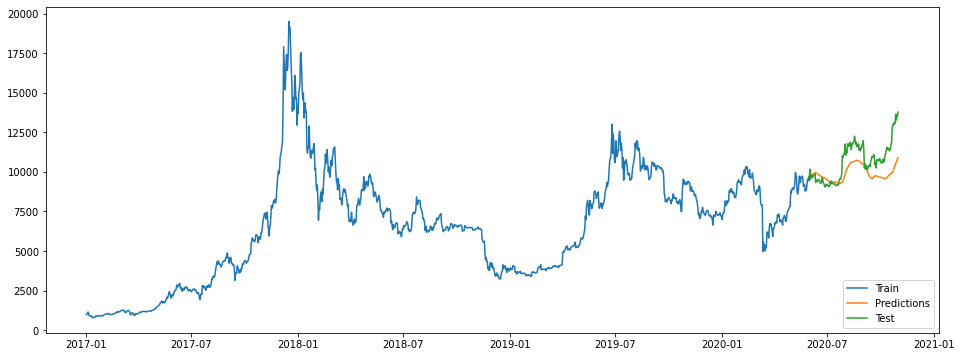

1184.462000304966

In [ ]:
train = data[:train_size_stat+1]
test = data[train_size_stat+1:]

#df = (np.exp(predictions.cumsum())*close[:train_size_stat+1].iloc[-1])
df = predictions.cumsum() + close[train_size_stat]
#df_train = predictions_train.cumsum() 



rmse = np.sqrt(np.mean(((df - test['Close']) ** 2)))
test['Stat-LSTM'] = df


# Visualize the data
plt.figure(figsize=(16,6))

plt.plot(train['Close'])
plt.plot(test[['Stat-LSTM','Close']])
plt.legend(['Train','Predictions','Test'], loc='lower right')
plt.show()
rmse

In [ ]:
 #save plots
# from google.colab import files
# plt.savefig("abc.png")
# files.download("abc.png") 